# **Extracting colors from images with Computer Vision**
### *This notebook implements a computer vision pipeline to extract dominant colors from clothing images, map them to predefined color palettes for eBay and Vinted platforms, and evaluate the performance using machine learning techniques. The pipeline includes data loading, image segmentation, color clustering, hyperparameter tuning, and performance visualization. The goal is to assess the accuracy of color extraction and mapping for two datasets, using YOLO for object detection and SAM for segmentation, followed by KMeans clustering to identify dominant colors.*

## **Setting-up**
#### We will start by setting up the required packages and libraries for image processing, machine learning, and visualization. These include OpenCV for image handling, NumPy and Pandas for data manipulation, Matplotlib and Seaborn for plotting, Scikit-learn for clustering and evaluation, and Ultralytics for segmentation models.

In [1]:
!pip install numpy ultralytics opencv-python scikit-learn matplotlib pandas seaborn torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 67.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 44.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

In [2]:
# Necessary libraries
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ultralytics import YOLO, SAM
from sklearn.cluster import KMeans
import matplotlib.ticker as mticker
import matplotlib.patches as patches
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


#### We set a fixed random seed to ensure consistent and reproducible results across runs, particularly for KMeans clustering.

In [3]:
# Ensure reproducibility
random_seed = 115
np.random.seed(random_seed)

#### The next cell defines RGB-to-color-name mappings for eBay and Vinted platforms, as well as for the two datasets we will be working with. These mappings standardize color names across platforms, enabling consistent color classification. The eBay and Vinted maps reflect their respective color naming conventions, while the dataset maps cover a broader range of colors present in the input data.

In [4]:
# Color maps for eBay, Vinted and the two datasets
color_map_ebay = {
    (245, 245, 220): "Beige", (0, 0, 0): "Black", (0, 0, 255): "Blue", (150, 75, 0): "Brown",
    (255, 215, 0): "Gold", (128, 128, 128): "Gray", (0, 128, 0): "Green", (255, 255, 240): "Ivory",
    (255, 165, 0): "Orange", (255, 192, 203): "Pink", (128, 0, 128): "Purple", (255, 0, 0): "Red",
    (192, 192, 192): "Silver", (255, 255, 255): "White", (255, 255, 0): "Yellow"
}

color_map_vinted = {
    (0, 0, 0): "Zwart", (150, 75, 0): "Bruin", (128, 128, 128): "Grijs", (245, 245, 220): "Beige",
    (255, 192, 203): "Roze", (128, 0, 128): "Paars", (255, 0, 0): "Rood", (255, 255, 0): "Geel",
    (0, 0, 255): "Blauw", (0, 128, 0): "Groen", (255, 165, 0): "Oranje", (255, 255, 255): "Wit",
    (192, 192, 192): "Zilver", (255, 215, 0): "Goud", (107, 142, 35): "Khaki", (64, 224, 208): "Turqoise",
    (255, 245, 235): "Creme", (255, 204, 153): "Pasteloranje", (102, 0, 0): "Wijnrood", (255, 127, 127): "Koraal",
    (255, 182, 193): "Lichtroze", (200, 162, 200): "Lila", (173, 216, 230): "Lichtblauw", (0, 0, 128): "Marineblauw",
    (0, 100, 0): "Donkergroen", (255, 219, 88): "Mosterdgeel", (152, 255, 152): "Mintgroen"
}

color_map_dataset1 = {
    'Navy Blue': (0, 0, 128), 'Blue': (0, 0, 255), 'Silver': (192, 192, 192), 'Black': (0, 0, 0),
    'Grey': (128, 128, 128), 'Green': (0, 128, 0), 'Purple': (128, 0, 128), 'White': (255, 255, 255),
    'Beige': (245, 245, 220), 'Brown': (150, 75, 0), 'Bronze': (205, 127, 50), 'Teal': (0, 128, 128),
    'Copper': (184, 115, 51), 'Pink': (255, 192, 203), 'Off White': (245, 245, 245), 'Maroon': (128, 0, 0),
    'Red': (255, 0, 0), 'Khaki': (107, 142, 35), 'Orange': (255, 165, 0), 'Coffee Brown': (111, 78, 55),
    'Yellow': (255, 255, 0), 'Charcoal': (54, 69, 79), 'Gold': (255, 215, 0), 'Steel': (112, 128, 144),
    'Tan': (210, 180, 140), 'Magenta': (255, 0, 255), 'Lavender': (230, 230, 250), 'Sea Green': (46, 139, 87),
    'Cream': (255, 255, 204), 'Peach': (255, 229, 180), 'Olive': (128, 128, 0), 'Skin': (255, 224, 189),
    'Burgundy': (128, 0, 32), 'Grey Melange': (160, 160, 160), 'Rust': (183, 65, 14), 'Rose': (255, 0, 127),
    'Lime Green': (50, 205, 50), 'Mauve': (224, 176, 255), 'Turquoise Blue': (0, 206, 209), 'Metallic': (192, 192, 192),
    'Mustard': (255, 219, 88), 'Taupe': (72, 60, 50), 'Nude': (240, 220, 190), 'Mushroom Brown': (104, 80, 68),
    'Fluorescent Green': (0, 255, 0)
}

color_map_dataset2 = {
    'White': (255, 255, 255), 'Black': (0, 0, 0), 'Blue': (0, 0, 255), 'Pink': (255, 192, 203),
    'Red': (255, 0, 0), 'Olive': (128, 128, 0), 'Yellow': (255, 255, 0), 'Navy Blue': (0, 0, 128),
    'Magenta': (255, 0, 255), 'Grey': (128, 128, 128), 'Green': (0, 128, 0), 'Orange': (255, 165, 0),
    'Purple': (128, 0, 128), 'Turquoise Blue': (0, 206, 209), 'Peach': (255, 229, 180), 'Off White': (245, 245, 245),
    'Teal': (0, 128, 128), 'Sea Green': (46, 139, 87), 'Lime Green': (50, 205, 50), 'Brown': (150, 75, 0),
    'Lavender': (230, 230, 250), 'Beige': (245, 245, 220), 'Khaki': (107, 142, 35), 'Maroon': (128, 0, 0),
    'Cream': (255, 255, 204), 'Rust': (183, 65, 14), 'Grey Melange': (160, 160, 160), 'Silver': (192, 192, 192),
    'Tan': (210, 180, 140), 'Charcoal': (54, 69, 79), 'Mushroom Brown': (104, 80, 68), 'Copper': (184, 115, 51),
    'Gold': (255, 215, 0), 'Bronze': (205, 127, 50), 'Taupe': (72, 60, 50), 'Mustard': (255, 219, 88),
    'Nude': (240, 220, 190)
}

#### We define three utility functions to support our pipeline:
#### **`find_closest_color`**: Identifies the closest color name within a specified color map, given an input RGB value. It uses LAB color space for perceptually accurate distance calculations.
#### **`get_rgb_for_color`**: It takes a color name and retrieves the RGB values from a color map. These values are formatted for another function by normalizing them (0-1 scale).
#### **`plot_color_mapping`**: Visualizes the mapping of the dataset ground-truth colors to their closest eBay and Vinted color names.

In [5]:
def find_closest_color(rgb, color_map):
    rgb_array = np.array([[rgb]], dtype=np.uint8)
    lab_array = cv2.cvtColor(rgb_array, cv2.COLOR_RGB2LAB)
    lab = lab_array[0, 0].astype(float)
    min_distance = float('inf')
    closest_color = "Unknown"
    for color_rgb, color_name in color_map.items():
        color_rgb_array = np.array([[color_rgb]], dtype=np.uint8)
        color_lab_array = cv2.cvtColor(color_rgb_array, cv2.COLOR_RGB2LAB)
        color_lab = color_lab_array[0, 0].astype(float)
        distance = np.sqrt(np.sum((lab - color_lab) ** 2))
        if distance < min_distance:
            min_distance = distance
            closest_color = color_name
    return closest_color

def get_rgb_for_color(color_name, color_map):
    if color_name in color_map.values():
        for rgb, name in color_map.items():
            if name == color_name:
                return tuple(c / 255.0 for c in rgb)
    elif color_name in color_map:
        rgb = color_map[color_name]
        return tuple(c / 255.0 for c in rgb)
    return (0, 0, 0)

def plot_color_mapping(color_names, rgb_map, title):
    mapped_results = []
    for color_name in color_names:
        rgb_value = rgb_map.get(color_name)
        if rgb_value is None:
            continue
        ebay_match = find_closest_color(rgb_value, color_map_ebay)
        vinted_match = find_closest_color(rgb_value, color_map_vinted)
        mapped_results.append({
            'Original Color': color_name,
            'Closest eBay Color': ebay_match,
            'Closest Vinted Color': vinted_match
        })

    results = pd.DataFrame(mapped_results)
    fig, ax = plt.subplots(figsize=(20, len(results)))
    ax.axis('off')
    columns = ['Original Color', 'Closest eBay Color', 'Closest Vinted Color']
    n_cols = len(columns)
    n_rows = len(results)
    cell_width = 0.25
    cell_height = 0.03
    header_offset = cell_height * 1.3

    for i in range(n_rows):
        for j, col in enumerate(columns):
            color_name = results.iloc[i][col]
            if col == 'Original Color':
                rgb = get_rgb_for_color(color_name, rgb_map)
            elif col == 'Closest eBay Color':
                rgb = get_rgb_for_color(color_name, color_map_ebay)
            else:
                rgb = get_rgb_for_color(color_name, color_map_vinted)
            x_text = j * cell_width
            y = 1 - (i + 1) * cell_height - header_offset
            square = patches.Rectangle(
                (x_text, y), cell_width * 0.1, cell_height * 0.8,
                facecolor=rgb, edgecolor='black'
            )
            ax.add_patch(square)
            ax.text(
                x_text + cell_width * 0.12, y + cell_height * 0.4,
                color_name, va='center', ha='left', fontsize=10
            )

    for j, col in enumerate(columns):
        ax.text(
            j * cell_width + cell_width * 0.12, 1 - cell_height * 0.5,
            col, va='center', ha='left', fontsize=12, fontweight='bold'
        )

    ax.set_xlim(0, n_cols * cell_width)
    ax.set_ylim(-header_offset - n_rows * 0.33 * cell_height)
    plt.title(title, fontsize=14)
    plt.tight_layout()
    plt.savefig("Color Mapping")
    plt.show()

## **Data Loading, Preprocessing & Visualization**

#### **`load_dataset`**: This function extracts a dataset from a ZIP file containing fashion images and reads the associated CSV file with metadata. It unzips the file and loads the CSV into a pandas DataFrame, handling any malformed lines by skipping them.

#### **`preprocess_dataset`**: This function preprocesses the loaded dataset to prepare it for analysis. For the 'fashion.csv' dataset, it filters rows to include only the 'Apparel' category and removes colors that appear fewer than twice to ensure sufficient samples for stratified sampling. For both datasets, it removes rows with the ambiguous 'Multi' label or missing color values and adds an `image_path` column constructed with the image ID column.

#### **`visualize_dataset`** This is used to generate a pie chart to display the distribution of colors in the dataset. It uses the dataset's color map for accurate visual color representation and the size of the slice reflects the distribution proportionally.

In [6]:
def load_dataset(zip_file, csv_file, id_column, category_column, color_column):
    !unzip -o {zip_file}
    data = pd.read_csv(csv_file, on_bad_lines='skip')
    data = preprocess_dataset(data, csv_file, id_column, category_column, color_column)
    return data

def preprocess_dataset(data, csv_file, id_column, category_column, color_column):
    if csv_file == 'fashion.csv':
        data = data[data[category_column] == 'Apparel'] # Remove other category 'Footwear' from second dataset

        # Filter out classes with fewer than 2 samples
        color_counts = data[color_column].value_counts()
        valid_colors = color_counts[color_counts >= 2].index
        data = data[data[color_column].isin(valid_colors)]

    data['image_path'] = data[id_column].apply(lambda x: f'images/{x}.jpg')
    data = data[(data[color_column] != 'Multi') & (data[color_column].notna())] # Remove 'NaN' and 'Multi'
    return data

def visualize_dataset(data, color_column, rgb_map, title):
    color_counts = data[color_column].value_counts()
    sizes = color_counts.values
    colors = [tuple(np.array(rgb_map[color_name]) / 255) for color_name in color_counts.index]
    plt.figure(figsize=(15, 12))
    plt.pie(sizes, colors=colors, startangle=90, textprops={'fontsize': 10},
            wedgeprops={'edgecolor': 'black', 'linewidth': 0.2})
    plt.title(title, fontsize=14)
    plt.axis('equal')
    if color_column  == "baseColour":
        plt.savefig("Color Distribution 1")
    else:
        plt.savefig("Color Distribution 2")
    plt.show()

#### Make sure to download the ZIP file `cv_data.zip` from the Github repository and place it in the correct directory to execute the next cells succesfully. We will use our previously defined functions to load them into our environment and plot the distribution of unique colors, as well as the color mapping from ground truth to our platform colors.

In [8]:
# Load datasets
color_data1 = load_dataset(
    zip_file='cv_data.zip',
    csv_file='styles.csv',
    id_column='id',
    category_column='masterCategory',
    color_column='baseColour'
)
color_data2 = load_dataset(
    zip_file='cv_data.zip',
    csv_file='fashion.csv',
    id_column='ProductId',
    category_column='Category',
    color_column='Colour'
)

Streaming output truncated to the last 5000 lines.
  inflating: images/58129.jpg        
  inflating: images/5813.jpg         
  inflating: images/58131.jpg        
  inflating: images/58132.jpg        
  inflating: images/58133.jpg        
  inflating: images/58135.jpg        
  inflating: images/58136.jpg        
  inflating: images/58137.jpg        
  inflating: images/58138.jpg        
  inflating: images/58139.jpg        
  inflating: images/5814.jpg         
  inflating: images/58140.jpg        
  inflating: images/58141.jpg        
  inflating: images/58143.jpg        
  inflating: images/58144.jpg        
  inflating: images/58145.jpg        
  inflating: images/58146.jpg        
  inflating: images/58147.jpg        
  inflating: images/58148.jpg        
  inflating: images/58149.jpg        
  inflating: images/5815.jpg         
  inflating: images/58150.jpg        
  inflating: images/58151.jpg        
  inflating: images/58152.jpg        
  inflating: images/58153.jpg        

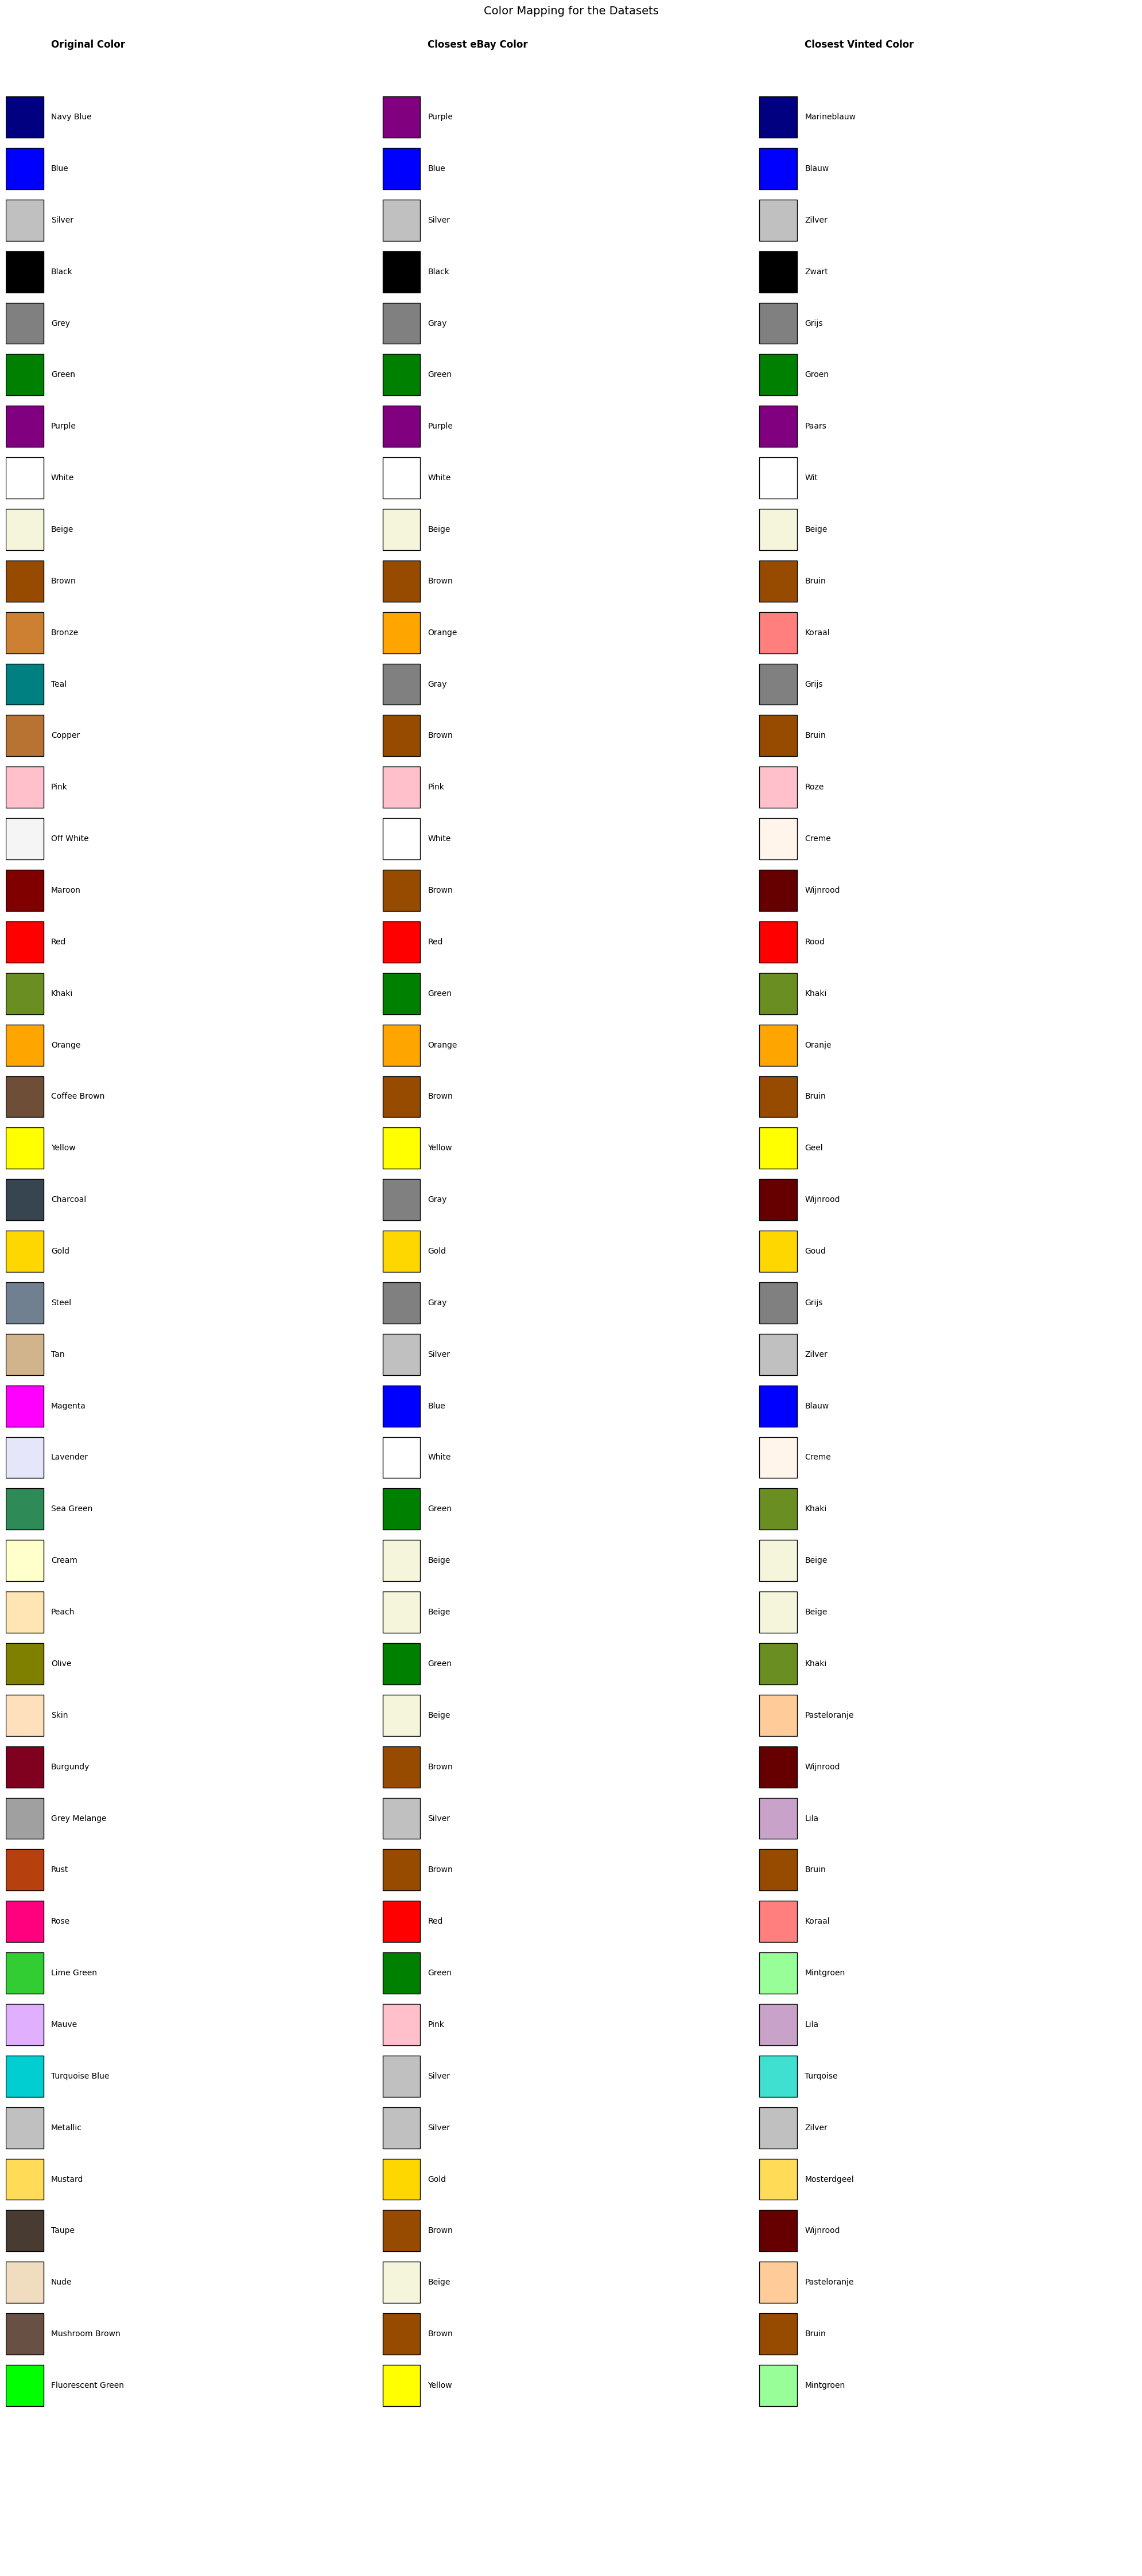

In [9]:
#Color map
plot_color_mapping(color_map_dataset1.keys(), color_map_dataset1, 'Color Mapping for the Datasets')

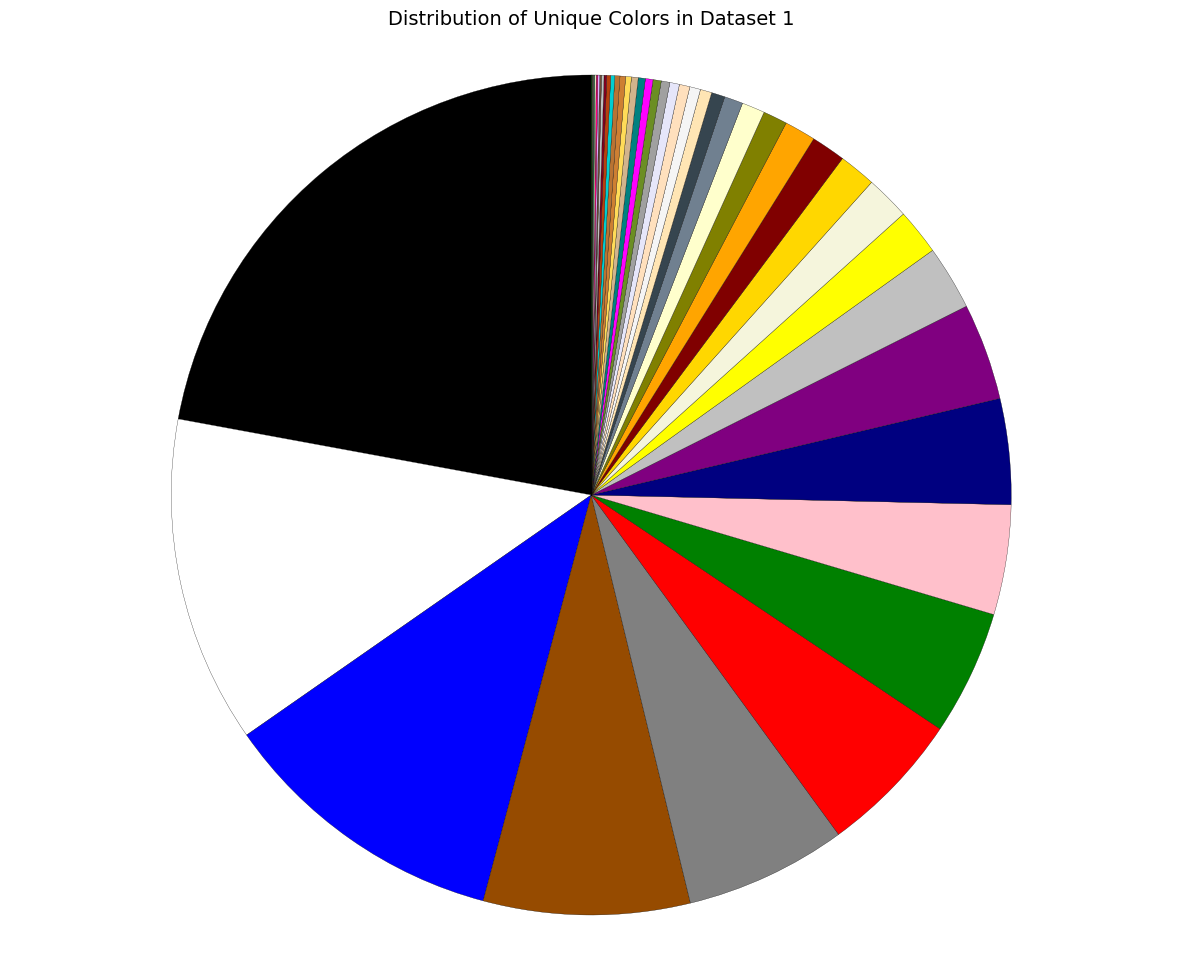

In [10]:
# Visualize Dataset 1
visualize_dataset(color_data1, 'baseColour', color_map_dataset1, 'Distribution of Unique Colors in Dataset 1')

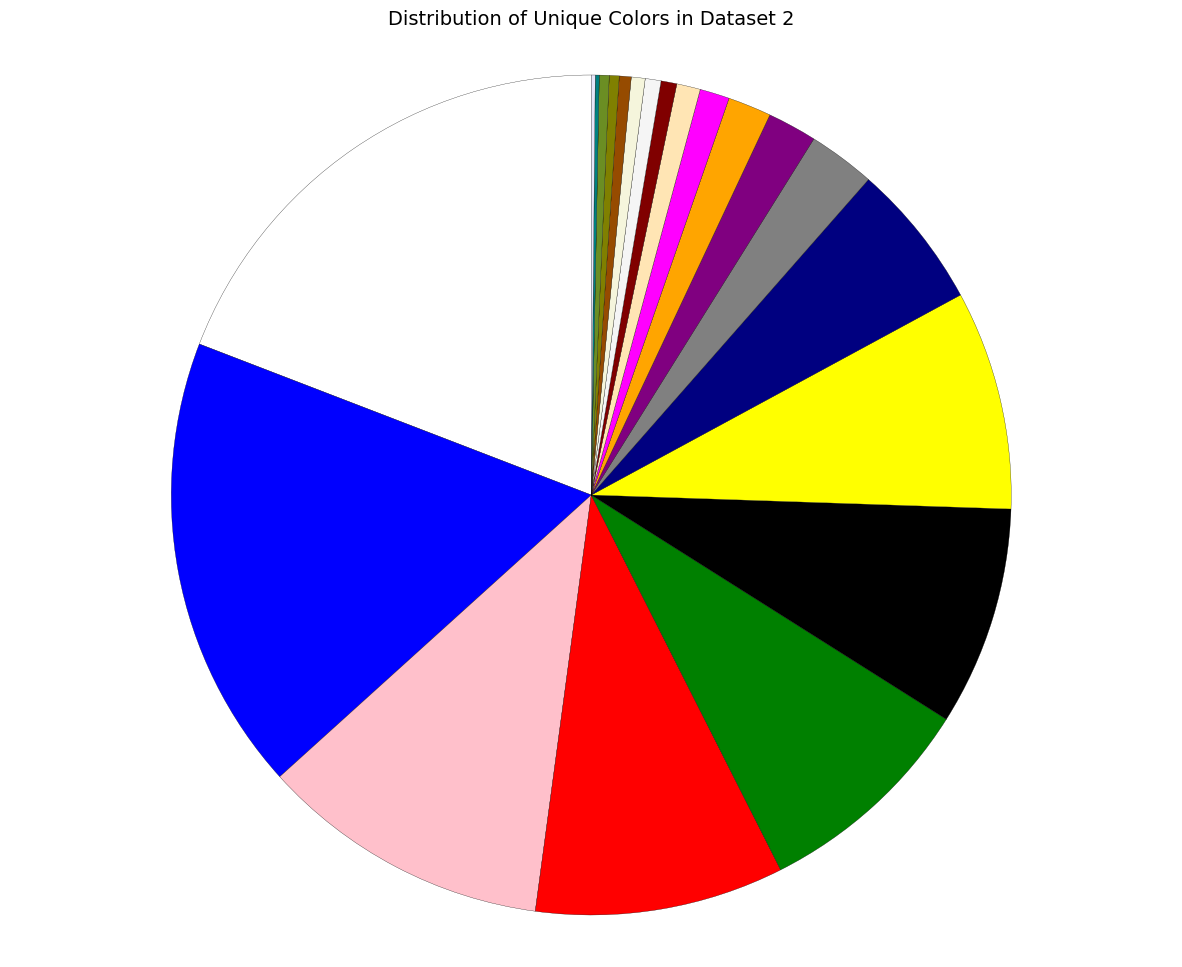

In [11]:
# Visualize Dataset 2
visualize_dataset(color_data2, 'Colour', color_map_dataset2, 'Distribution of Unique Colors in Dataset 2')

#### As you can see, the datsets show a stark imbalance, which will motivate our decision of taking a stratified approach during hyperparameter tuning and evaluation.

In [12]:
print(f"Top 7 least occurring colors in Dataset 1 (size: {len(color_data1)} images):")
print(color_data1['baseColour'].value_counts().tail(7))
print("\n")
print(f"Top 7 least occurring colors in Dataset 2 (size: {len(color_data2)} images):")
print(color_data2['Colour'].value_counts().tail(7))

Top 7 least occurring colors in Dataset 1 (size: 44015 images):
baseColour
Rose                 28
Nude                 23
Sea Green            22
Mushroom Brown       16
Taupe                11
Lime Green            6
Fluorescent Green     5
Name: count, dtype: int64


Top 7 least occurring colors in Dataset 2 (size: 1316 images):
Colour
Off White    8
Beige        7
Brown        6
Olive        5
Khaki        5
Teal         2
Lavender     2
Name: count, dtype: int64


## **Segmentation Models**
#### **YOLO Model**: Uses `yolo11x-seg.pt` for object detection and segmentation, although only the latter is directly relevant. Alternatively, you can use the older V8 model with `yolov8x-seg.pt`, as well use smaller versions of both, by changing `x` to, `l` (large), `m` (medium), `s` (small), or `n` (nano).
#### **SAM Model**: Uses the `sam2_b.pt` base model for high-quality segmentation (alternative consist of `sam2_l.pt` or `sam2_t.pt`, for different accuracy-speed trade-offs).

In [13]:
yolo_model = YOLO('yolo11x-seg.pt')
sam_model = SAM('sam2_b.pt')

100%|██████████| 119M/119M [00:00<00:00, 335MB/s] 


100%|██████████| 154M/154M [00:03<00:00, 49.9MB/s]


#### The **`process_image`** function  takes an image path and first segments the garment from its background using the specified model, next, extracts the pixels from the segmented region (or the entire image if segmentation fails), then applies KMeans clustering to identify the dominant color, and finally maps it to both an eBay and Vinted color name.


In [14]:
def process_image(image_path, model, model_type, n_clusters, max_iter, verbose=False):
    image_bgr = cv2.imread(image_path)
    if image_bgr is None:
        if verbose:
            print(f"Error: Could not load image at {image_path}")
        return None
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    segmentation_success = False
    pixels = None

    if model_type == 'yolo':
        results = model.predict(image_rgb, imgsz=640, verbose=False)
        if results and results[0].masks:
            masks = results[0].masks.xy
            binary_mask = np.zeros(image_rgb.shape[:2], dtype=np.uint8)
            mask_coords = np.array(masks[0], dtype=np.int32).reshape(-1, 1, 2)
            cv2.fillPoly(binary_mask, [mask_coords], 1)
            pixels = image_rgb[binary_mask == 1]
            segmentation_success = True
        else:
            if verbose:
                print(f"No segmentation masks found for {image_path} with YOLO. Using whole image.")
            pixels = image_rgb.reshape(-1, 3)
    elif model_type == 'sam':
        h, w = image_rgb.shape[:2]
        side = min(w, h) * 0.1  # Side length is 10% of image dimension
        center_x, center_y = w / 2, h / 2

        point_coords = [[center_x, center_y]]
        point_labels = [1] # 'Focus point' (as oppposed to 'ignore' point; less attention)
        results = model(image_rgb, points=point_coords, labels=point_labels, imgsz=640, verbose=False)
        if results and results[0].masks is not None:
            mask = results[0].masks.data[0].cpu().numpy()
            binary_mask = (mask > 0.5).astype(np.uint8)
            pixels = image_rgb[binary_mask == 1]
            if len(pixels) > n_clusters:
                segmentation_success = True
            else:
                if verbose:
                    print(f"No valid pixels in mask for {image_path} with SAM2. Using whole image.")
                pixels = image_rgb.reshape(-1, 3)
        else:
            if verbose:
                print(f"No segmentation masks found for {image_path} with SAM2. Using whole image.")
            pixels = image_rgb.reshape(-1, 3)
    else:
        raise ValueError("model_type must be 'yolo' or 'sam'")

    # Apply KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_seed, n_init='auto', max_iter=max_iter)
    kmeans.fit(pixels)
    labels = kmeans.labels_
    cluster_sizes = np.bincount(labels)
    dominant_cluster_idx = np.argmax(cluster_sizes)
    pred_rgb = kmeans.cluster_centers_[dominant_cluster_idx].astype(int)

    # Map predicted RGB to color names
    ebay_color = find_closest_color(pred_rgb, color_map_ebay)
    vinted_color = find_closest_color(pred_rgb, color_map_vinted)

    return {
        'ebay_color': ebay_color,
        'vinted_color': vinted_color,
        'dominant_rgb': pred_rgb,
        'segmentation_success': segmentation_success
    }

## **Tuning Hyperparameters**
#### **`CustomKMeans` Class**: A wrapper for KMeans that fits a model for each image's pixels to deal with varying resolution across images.
#### **`custom_scorer`**: The function evaluates KMeans performance by comparing predicted eBay colors to ground truth (0 for misclassifications, 1 for correct ones). It is used in grid search to help determine the best hyperparameters.
#### **`tune_kmeans`**: Performs grid search over the `n_clusters` and `max_iter` parameters to optimize KMeans clustering by maximizing the eBay F1-score. Performance is evaluated using accuracy, precision, recall, and F1-score for both eBay and Vinted mappings and the results are then visualized.


In [15]:
class CustomKMeans(BaseEstimator, ClusterMixin):
    def __init__(self, n_clusters=3, init='k-means++', max_iter=300, random_state=None, n_init='auto'):
        self.n_clusters = n_clusters
        self.init = init
        self.max_iter = max_iter
        self.random_state = random_state
        self.n_init = n_init
        self.kmeans = None

    def fit(self, X, y=None):
        self.models_ = []
        for pixels in X:
            kmeans = KMeans(
                n_clusters=self.n_clusters,
                init=self.init,
                max_iter=self.max_iter,
                random_state=self.random_state,
                n_init=self.n_init
            )
            kmeans.fit(pixels)
            self.models_.append(kmeans)
        return self

    def predict(self, X):
        predictions = []
        for pixels, model in zip(X, self.models_):
            labels = model.labels_
            cluster_sizes = np.bincount(labels)
            dominant_cluster_idx = np.argmax(cluster_sizes)
            pred_rgb = model.cluster_centers_[dominant_cluster_idx].astype(int)
            predictions.append(pred_rgb)
        return predictions

def custom_scorer(estimator, X, y_true, rgb_map, color_column, data_subset):
    pred_rgbs = estimator.predict(X)
    ebay_score = 0.0
    vinted_score = 0.0
    for pred_rgb, gt_ebay_color, row in zip(pred_rgbs, y_true, data_subset.iterrows()):
        # eBay color prediction
        pred_ebay_color = find_closest_color(pred_rgb, color_map_ebay)
        ebay_score += 1.0 if pred_ebay_color == gt_ebay_color else 0.0

        # Vinted color prediction
        color_label = row[1][color_column]
        gt_rgb = rgb_map.get(color_label)
        if gt_rgb is None:
            continue
        gt_vinted_color = find_closest_color(gt_rgb, color_map_vinted)
        pred_vinted_color = find_closest_color(pred_rgb, color_map_vinted)
        vinted_score += 1.0 if pred_vinted_color == gt_vinted_color else 0.0

    ebay_accuracy = ebay_score / len(X) if len(X) > 0 else 0.0
    vinted_accuracy = vinted_score / len(X) if len(X) > 0 else 0.0

    # Combine scores (e.g., equal weights)
    weight_ebay = 0.5
    weight_vinted = 0.5
    combined_score = weight_ebay * ebay_accuracy + weight_vinted * vinted_accuracy

    return combined_score

from functools import partial

def tune_kmeans(data, rgb_map, color_column, num_samples, model, title, model_type, verbose=False):
    # Perform stratified sampling
    strat_split = StratifiedShuffleSplit(n_splits=1, train_size=num_samples, random_state=random_seed)
    X_indices = np.arange(len(data))
    y_labels = data[color_column].values
    train_idx, _ = next(strat_split.split(X_indices, y_labels))
    sampled_data = data.iloc[train_idx]

    X, y = [], []
    param_grid = {
        'n_clusters': [2, 3, 4, 5, 6, 7, 8, 9, 10],
        'max_iter': [10, 50, 100, 200]
    }
    for index, row in sampled_data.iterrows():
        image_path = row['image_path']
        color_label = row[color_column]
        gt_rgb = rgb_map.get(color_label)

        image_bgr = cv2.imread(image_path)
        image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

        if model_type == 'yolo':
            results = model.predict(image_rgb, imgsz=640, verbose=False)
            if results and results[0].masks:
                masks = results[0].masks.xy
                binary_mask = np.zeros(image_rgb.shape[:2], dtype=np.uint8)
                mask_coords = np.array(masks[0], dtype=np.int32).reshape(-1, 1, 2)
                cv2.fillPoly(binary_mask, [mask_coords], 1)
                pixels = image_rgb[binary_mask == 1]
            else:
                pixels = image_rgb.reshape(-1, 3)
        elif model_type == 'sam':
            h, w = image_rgb.shape[:2]
            side = min(w, h) * 0.1
            center_x, center_y = w / 2, h / 2
            point_coords = [[center_x, center_y]]
            point_labels = [1]
            results = model(image_rgb, points=point_coords, labels=point_labels, imgsz=640, verbose=False)
            if results and results[0].masks is not None:
                mask = results[0].masks.data[0].cpu().numpy()
                binary_mask = (mask > 0.5).astype(np.uint8)
                pixels = image_rgb[binary_mask == 1]
                if len(pixels) >= max(param_grid['n_clusters']):
                    segmentation_success = True
                else:
                    if verbose:
                        print(f"No valid pixels in mask for {image_path} with SAM2. Using whole image.")
                    pixels = image_rgb.reshape(-1, 3)
            else:
                if verbose:
                    print(f"No segmentation masks found for {image_path} with SAM2. Using whole image.")
                pixels = image_rgb.reshape(-1, 3)
        else:
            raise ValueError("model_type must be 'yolo' or 'sam'")

        if len(pixels) >= max(param_grid['n_clusters']):
            X.append(pixels)
            y.append(find_closest_color(gt_rgb, color_map_ebay))
        elif verbose:
            print(f"Skipping image {image_path} due to insufficient pixels ({len(pixels)}) for KMeans tuning.")

    custom_kmeans = CustomKMeans(random_state=random_seed)
    # Bind additional arguments to custom_scorer
    scorer = partial(custom_scorer, rgb_map=rgb_map, color_column=color_column, data_subset=sampled_data)
    grid_search = GridSearchCV(
        estimator=custom_kmeans,
        param_grid=param_grid,
        scoring=scorer,
        cv=[(np.arange(len(X)), np.arange(len(X)))],
        n_jobs=-1,
        verbose=1,
        error_score='raise'
    )
    grid_search.fit(X, y)
    results_df = pd.DataFrame(grid_search.cv_results_)

    all_results = []
    for params, mean_score in zip(results_df['params'], results_df['mean_test_score']):
        ebay_true, ebay_pred, vinted_true, vinted_pred = [], [], [], []
        for pixels, gt_ebay_color, row in zip(X, y, sampled_data.iterrows()):
            color_label = row[1][color_column]
            gt_rgb = rgb_map.get(color_label)
            if gt_rgb is None:
                continue
            kmeans = KMeans(
                n_clusters=params['n_clusters'],
                max_iter=params['max_iter'],
                random_state=random_seed,
                n_init='auto'
            )
            kmeans.fit(pixels)
            labels = kmeans.labels_
            cluster_sizes = np.bincount(labels)
            dominant_cluster_idx = np.argmax(cluster_sizes)
            pred_rgb = kmeans.cluster_centers_[dominant_cluster_idx].astype(int)
            pred_ebay_color = find_closest_color(pred_rgb, color_map_ebay)
            pred_vinted_color = find_closest_color(pred_rgb, color_map_vinted)
            gt_vinted_color = find_closest_color(gt_rgb, color_map_vinted)
            ebay_true.append(gt_ebay_color)
            ebay_pred.append(pred_ebay_color)
            vinted_true.append(gt_vinted_color)
            vinted_pred.append(pred_vinted_color)

        ebay_accuracy = accuracy_score(ebay_true, ebay_pred)
        ebay_precision, ebay_recall, ebay_f1, _ = precision_recall_fscore_support(
            ebay_true, ebay_pred, average='weighted', zero_division=0)
        vinted_accuracy = accuracy_score(vinted_true, vinted_pred)
        vinted_precision, vinted_recall, vinted_f1, _ = precision_recall_fscore_support(
            vinted_true, vinted_pred, average='weighted', zero_division=0)

        all_results.append({
            'n_clusters': params['n_clusters'],
            'max_iter': params['max_iter'],
            'mean_test_score': mean_score,
            'ebay_accuracy': ebay_accuracy,
            'ebay_precision': ebay_precision,
            'ebay_recall': ebay_recall,
            'ebay_f1': ebay_f1,
            'vinted_accuracy': vinted_accuracy,
            'vinted_precision': vinted_precision,
            'vinted_recall': vinted_recall,
            'vinted_f1': vinted_f1
        })

    detailed_results_df = pd.DataFrame(all_results)
    # Select best configuration based on combined score
    best_config = detailed_results_df.loc[detailed_results_df['mean_test_score'].idxmax()]
    if verbose:
        print(f"KMeans Hyperparameter Tuning Results for {title} ({model_type.upper()}):")
        print(detailed_results_df.to_string(index=False))
        print(f"eBay: Accuracy={best_config['ebay_accuracy']:.4f}, Precision={best_config['ebay_precision']:.4f}, "
              f"Recall={best_config['ebay_recall']:.4f}, F1={best_config['ebay_f1']:.4f}")
        print(f"Vinted: Accuracy={best_config['vinted_accuracy']:.4f}, Precision={best_config['vinted_precision']:.4f}, "
              f"Recall={best_config['vinted_recall']:.4f}, F1={best_config['vinted_f1']:.4f}")
        print(f"\nBest Configuration for {title} ({model_type.upper()}) (based on combined eBay-Vinted score):")
        print(f"n_clusters: {best_config['n_clusters']}, max_iter: {best_config['max_iter']}")

    plt.figure(figsize=(10, 6))
    for max_iter in param_grid['max_iter']:
        subset = detailed_results_df[detailed_results_df['max_iter'] == max_iter]
        plt.plot(subset['n_clusters'], subset['ebay_f1'], marker='o',
                 label=f'eBay F1 (max_iter={max_iter})')
        plt.plot(subset['n_clusters'], subset['vinted_f1'], marker='s',
                 label=f'Vinted F1 (max_iter={max_iter})')
    plt.xlabel('Number of Clusters')
    plt.ylabel('F1 Score')
    plt.title(f'KMeans Hyperparameter Tuning ({title}, {model_type.upper()}, {num_samples} samples)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"Grid Search Results {title} {model_type.upper()} {num_samples}")
    plt.show()

    return {
        'n_clusters': int(best_config['n_clusters']),
        'max_iter': int(best_config['max_iter'])
    }

## **Evaluation**
#### **`evaluate_model`**: Processes a specified number of images by first extracting dominant colors, mapping them to eBay and Vinted color names, to then compute and store evaluation metrics for both platforms.
#### **`visualize_evaluation`**: Creates bar plots comparing relevant eBay and Vinted metrics and a pie chart showing the segmentation success rates.


In [16]:
def evaluate_model(data, rgb_map, color_column, num_samples, model, n_clusters, max_iter, model_type='yolo', verbose=False):
    # Perform stratisfied sampling for the first dataset
    if color_column == 'baseColour':
        strat_split = StratifiedShuffleSplit(n_splits=1, train_size=num_samples, random_state=random_seed)

        X_indices = np.arange(len(data))
        y_labels = data[color_column].values
        train_idx, _ = next(strat_split.split(X_indices, y_labels))

        data = data.iloc[train_idx]

    ebay_true, ebay_pred, vinted_true, vinted_pred = [], [], [], []
    segmentation_results = {'Yes': 0, 'No': 0}

    for index, row in data.iterrows():
        image_path = row['image_path']
        color_label = row[color_column]
        gt_rgb = rgb_map.get(color_label)
        if gt_rgb is None:
            continue
        result = process_image(image_path, model, model_type, n_clusters, max_iter)
        if result:
            pred_rgb = result['dominant_rgb']
            pred_ebay_color = result['ebay_color']
            pred_vinted_color = result['vinted_color']
            gt_ebay_color = find_closest_color(gt_rgb, color_map_ebay)
            gt_vinted_color = find_closest_color(gt_rgb, color_map_vinted)
            if result['segmentation_success']:
                segmentation_results['Yes'] += 1
            else:
                segmentation_results['No'] += 1
            ebay_true.append(gt_ebay_color)
            ebay_pred.append(pred_ebay_color)
            vinted_true.append(gt_vinted_color)
            vinted_pred.append(pred_vinted_color)

    ebay_accuracy = accuracy_score(ebay_true, ebay_pred)
    ebay_precision, ebay_recall, ebay_f1, _ = precision_recall_fscore_support(
        ebay_true, ebay_pred, average='weighted', zero_division=0)
    vinted_accuracy = accuracy_score(vinted_true, vinted_pred)
    vinted_precision, vinted_recall, vinted_f1, _ = precision_recall_fscore_support(
        vinted_true, vinted_pred, average='weighted', zero_division=0)

    if verbose:
        print(f"Evaluation Results ({model_type.upper()}):")
        print(f"eBay: Accuracy={ebay_accuracy:.4f}, Precision={ebay_precision:.4f}, "
              f"Recall={ebay_recall:.4f}, F1={ebay_f1:.4f}")
        print(f"Vinted: Accuracy={vinted_accuracy:.4f}, Precision={vinted_precision:.4f}, "
              f"Recall={vinted_recall:.4f}, F1={vinted_f1:.4f}")

    return {
        'ebay_accuracy': ebay_accuracy,
        'ebay_precision': ebay_precision,
        'ebay_recall': ebay_recall,
        'ebay_f1': ebay_f1,
        'vinted_accuracy': vinted_accuracy,
        'vinted_precision': vinted_precision,
        'vinted_recall': vinted_recall,
        'vinted_f1': vinted_f1,
        'segmentation_results': segmentation_results
    }

def visualize_evaluation(evaluation_results, title, num_samples, model_type, verbose=False):
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    ebay_values = [evaluation_results['ebay_accuracy'], evaluation_results['ebay_precision'],
                   evaluation_results['ebay_recall'], evaluation_results['ebay_f1']]
    vinted_values = [evaluation_results['vinted_accuracy'], evaluation_results['vinted_precision'],
                     evaluation_results['vinted_recall'], evaluation_results['vinted_f1']]

    # Bar plot
    x = np.arange(len(metrics))
    width = 0.3
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(x - width/2, ebay_values, width=width, label='eBay', color='#66b3ff')
    ax.bar(x + width/2, vinted_values, width=width, label='Vinted', color='#ff9999')
    ax.set_ylabel('Scores (in %)')
    ax.set_title(f'Color Extraction Evaluation Metrics ({title}, {model_type.upper()}, {num_samples} Samples)')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.legend()
    ax.grid(axis='y')
    ax.set_ylim(0, 1)
    formatter = mticker.PercentFormatter(xmax=1.0)
    ax.yaxis.set_major_formatter(formatter)
    plt.tight_layout()
    plt.savefig(f"Color Extraction Results {model_type.upper()} {title} {num_samples}")
    plt.show()

    # Pie chart
    segmentation_results = evaluation_results['segmentation_results']

    # Define legend structure
    legend_labels = [f'Yes (Segmented Successfully with {model_type.upper()})', 'No (Whole Image Used)']
    sizes = [segmentation_results['Yes'], segmentation_results['No']]
    colors = ['#66c2a5', '#fc8d62']  # Green and orange for success and failure
    plt.figure(figsize=(15, 12))

    plt.pie(sizes, colors=colors, autopct='%1.1f%%',
            shadow=True, startangle=90, textprops={'fontsize': 12})

    plt.title(f'{model_type.upper()} Segmentation Success Rate ({title})', fontsize=14)
    plt.axis('equal')
    plt.legend(legend_labels, loc="best")
    plt.savefig(f"Succesful Segmentation Results {model_type.upper()} {title} {num_samples}")
    plt.show()
    if verbose:
        print(f"{title} ({model_type.upper()}) Successful Segmentations (Yes): {segmentation_results['Yes']}")
        print(f"{title} ({model_type.upper()}) Failed Segmentations (No): {segmentation_results['No']}")


#### We run the cell below to tune the KMeans clustering algorithm for both datasets with the YOLO and SAM segmentation models. Results are displayed as plots of F1-scores for eBay and Vinted mappings, as this was used for the evaluation of custom_scorer.


Fitting 1 folds for each of 36 candidates, totalling 36 fits
KMeans Hyperparameter Tuning Results for Dataset 1 (YOLO):
 n_clusters  max_iter  mean_test_score  ebay_accuracy  ebay_precision  ebay_recall  ebay_f1  vinted_accuracy  vinted_precision  vinted_recall  vinted_f1
          2        10           0.1590          0.190        0.331145        0.190 0.196550            0.128          0.292581          0.128   0.137908
          3        10           0.1730          0.204        0.334701        0.204 0.206726            0.142          0.279211          0.142   0.152094
          4        10           0.1805          0.212        0.335013        0.212 0.212919            0.149          0.276992          0.149   0.160770
          5        10           0.1895          0.220        0.347933        0.220 0.219464            0.159          0.298137          0.159   0.168245
          6        10           0.1895          0.220        0.335848        0.220 0.215013            0.159       

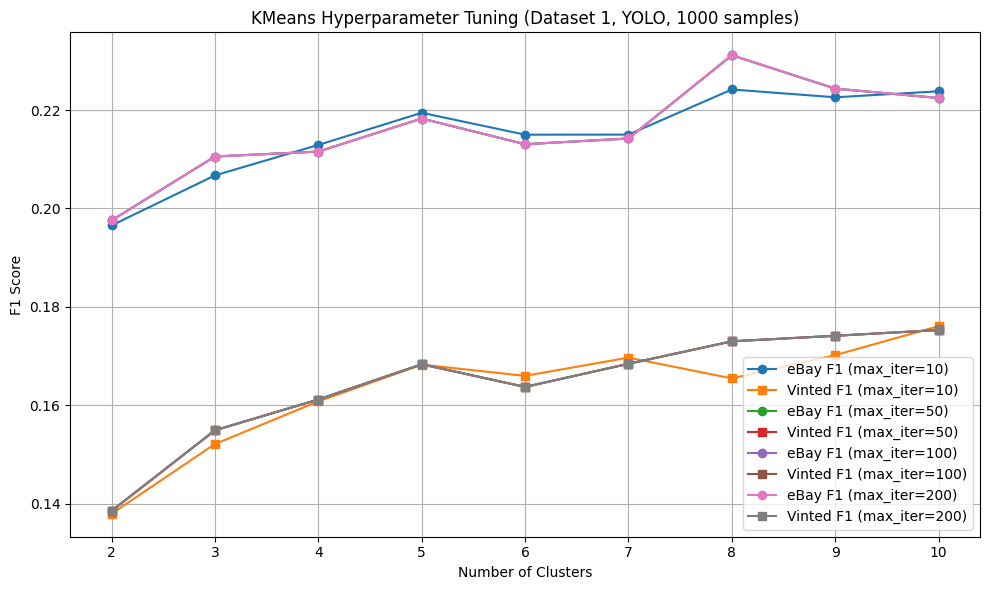

No valid pixels in mask for images/10701.jpg with SAM2. Using whole image.
No valid pixels in mask for images/54622.jpg with SAM2. Using whole image.
No valid pixels in mask for images/31185.jpg with SAM2. Using whole image.
No valid pixels in mask for images/59265.jpg with SAM2. Using whole image.
No valid pixels in mask for images/35334.jpg with SAM2. Using whole image.
No valid pixels in mask for images/20785.jpg with SAM2. Using whole image.
No valid pixels in mask for images/28937.jpg with SAM2. Using whole image.
Fitting 1 folds for each of 36 candidates, totalling 36 fits
KMeans Hyperparameter Tuning Results for Dataset 1 (SAM):
 n_clusters  max_iter  mean_test_score  ebay_accuracy  ebay_precision  ebay_recall  ebay_f1  vinted_accuracy  vinted_precision  vinted_recall  vinted_f1
          2        10           0.2035          0.246        0.318688        0.246 0.241151            0.161          0.262768          0.161   0.173895
          3        10           0.2210          0.

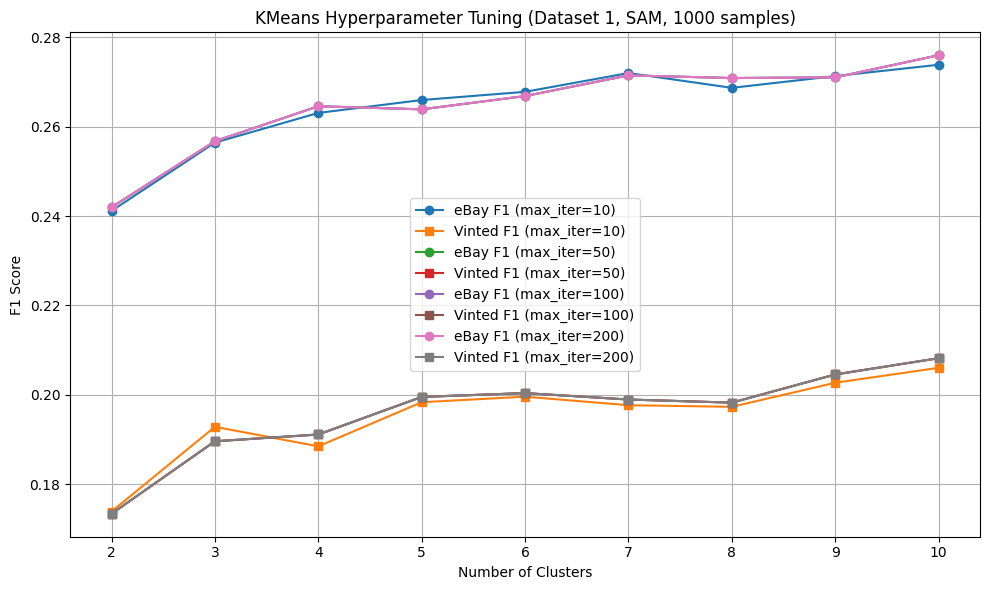

Fitting 1 folds for each of 36 candidates, totalling 36 fits
KMeans Hyperparameter Tuning Results for Dataset 2 (YOLO):
 n_clusters  max_iter  mean_test_score  ebay_accuracy  ebay_precision  ebay_recall  ebay_f1  vinted_accuracy  vinted_precision  vinted_recall  vinted_f1
          2        10           0.1875          0.207        0.361218        0.207 0.178498            0.168          0.308177          0.168   0.130855
          3        10           0.1945          0.217        0.368454        0.217 0.186636            0.172          0.359827          0.172   0.131862
          4        10           0.2045          0.236        0.381645        0.236 0.201974            0.173          0.297772          0.173   0.132696
          5        10           0.2125          0.239        0.376347        0.239 0.203952            0.186          0.353535          0.186   0.147559
          6        10           0.2070          0.229        0.373872        0.229 0.193848            0.185       

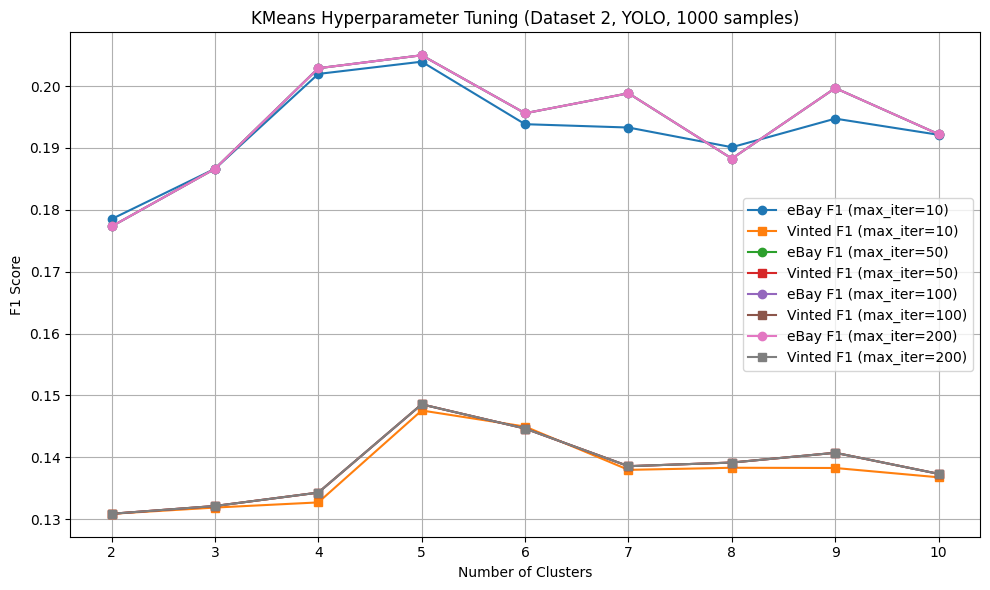

No valid pixels in mask for images/8381.jpg with SAM2. Using whole image.
No valid pixels in mask for images/3854.jpg with SAM2. Using whole image.
No valid pixels in mask for images/3892.jpg with SAM2. Using whole image.
No valid pixels in mask for images/8349.jpg with SAM2. Using whole image.
Fitting 1 folds for each of 36 candidates, totalling 36 fits
KMeans Hyperparameter Tuning Results for Dataset 2 (SAM):
 n_clusters  max_iter  mean_test_score  ebay_accuracy  ebay_precision  ebay_recall  ebay_f1  vinted_accuracy  vinted_precision  vinted_recall  vinted_f1
          2        10           0.1265          0.161        0.331632        0.161 0.191392            0.092          0.241804          0.092   0.114414
          3        10           0.1365          0.172        0.360623        0.172 0.206639            0.101          0.301531          0.101   0.130323
          4        10           0.1495          0.192        0.377297        0.192 0.229248            0.107          0.254776

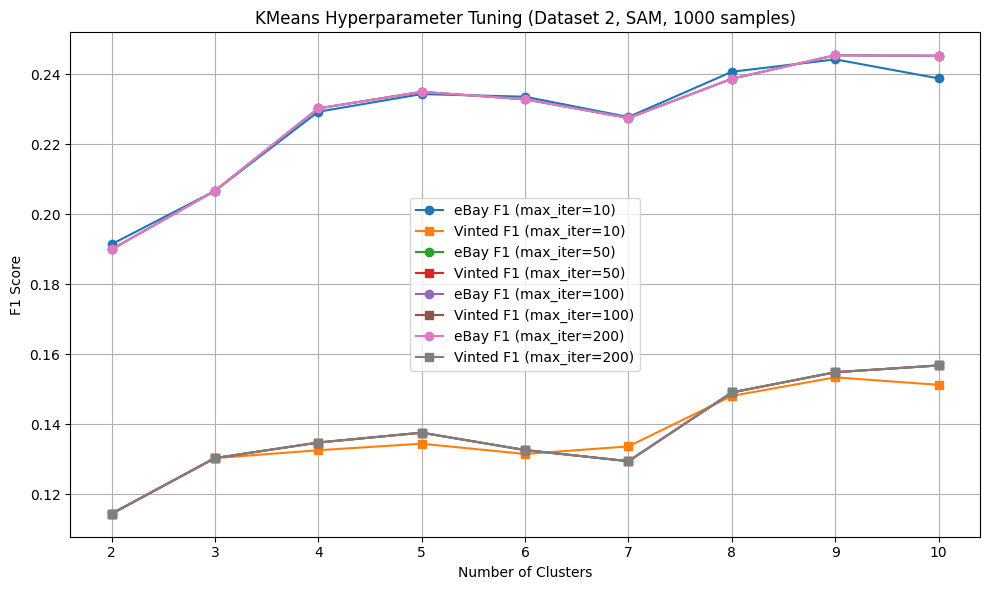

In [17]:
# Tune KMeans and store best hyperparameters
num_samples_tune = 1000

# Dataset 1, YOLO
best_params_d1_yolo = tune_kmeans(
    color_data1, color_map_dataset1, 'baseColour', num_samples_tune, yolo_model, 'Dataset 1', 'yolo', verbose=True
)
# Dataset 1, SAM
best_params_d1_sam = tune_kmeans(
    color_data1, color_map_dataset1, 'baseColour', num_samples_tune, sam_model, 'Dataset 1', 'sam', verbose=True
)
# Dataset 2, YOLO
best_params_d2_yolo = tune_kmeans(
    color_data2, color_map_dataset2, 'Colour', num_samples_tune, yolo_model, 'Dataset 2', 'yolo', verbose=True
)
# Dataset 2, SAM
best_params_d2_sam = tune_kmeans(
    color_data2, color_map_dataset2, 'Colour', num_samples_tune, sam_model, 'Dataset 2', 'sam', verbose=True
)

#### The last code cell evaluates the color extraction pipeline on both datasets for both models with the inferred hyperparameters. The functions we defined earlier provide the means for easy interpretation of the pipeline's effectiveness.


Evaluation Results (YOLO):
eBay: Accuracy=0.2272, Precision=0.3409, Recall=0.2272, F1=0.2217
Vinted: Accuracy=0.1679, Precision=0.2791, Recall=0.1679, F1=0.1703


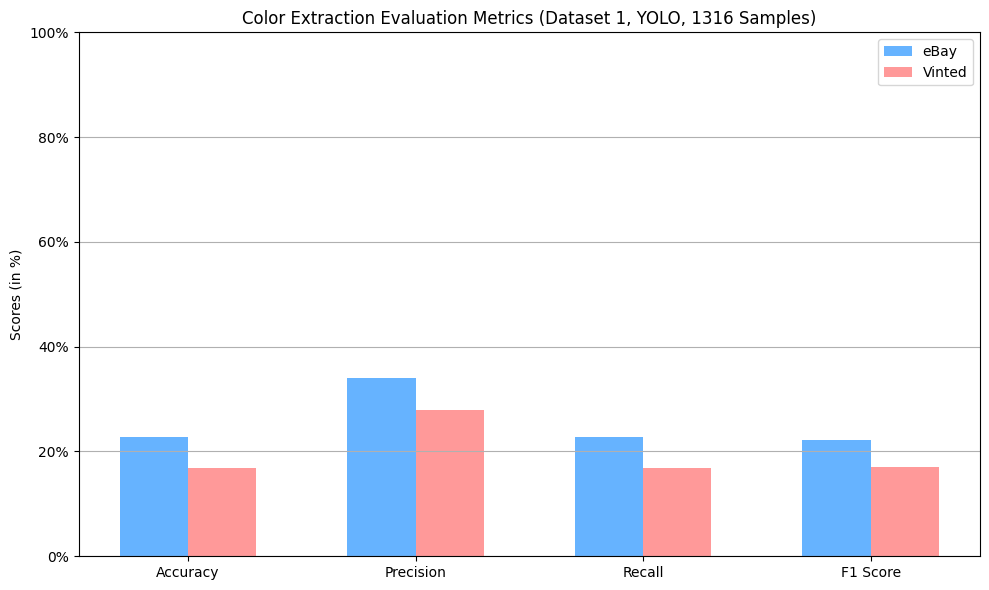

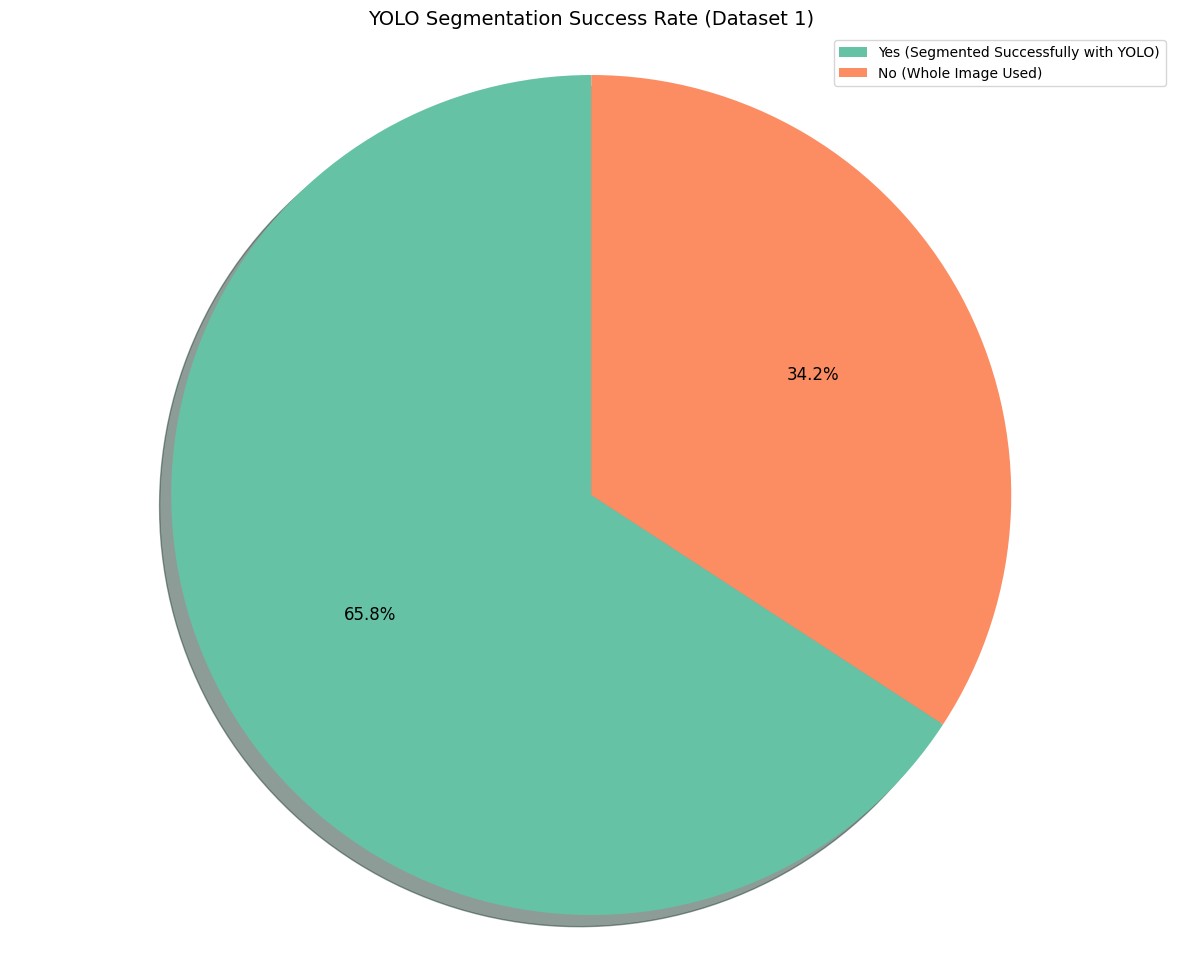

Dataset 1 (YOLO) Successful Segmentations (Yes): 866
Dataset 1 (YOLO) Failed Segmentations (No): 450
Evaluation Results (SAM):
eBay: Accuracy=0.2736, Precision=0.3630, Recall=0.2736, F1=0.2716
Vinted: Accuracy=0.1968, Precision=0.2973, Recall=0.1968, F1=0.2083


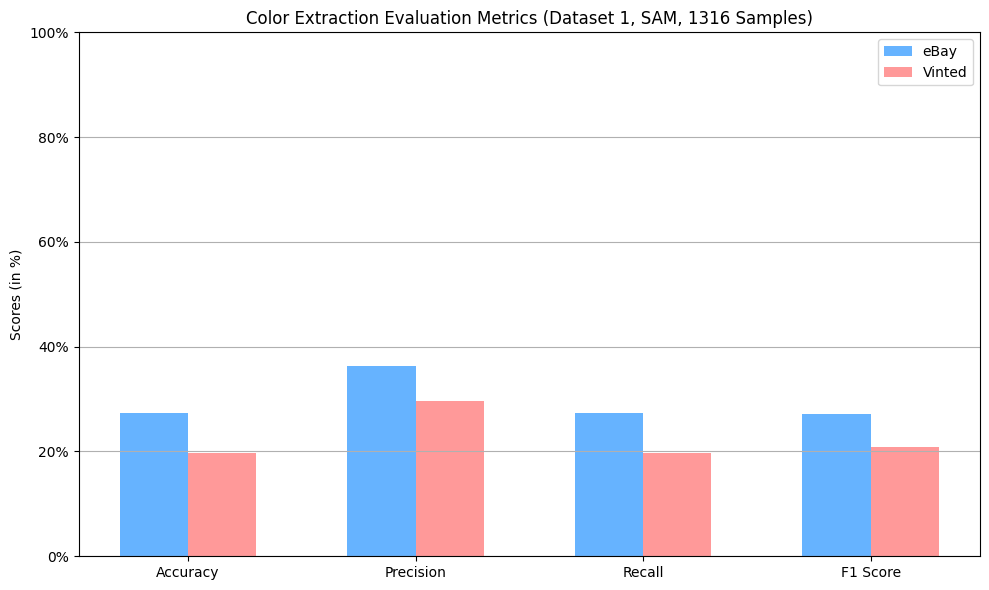

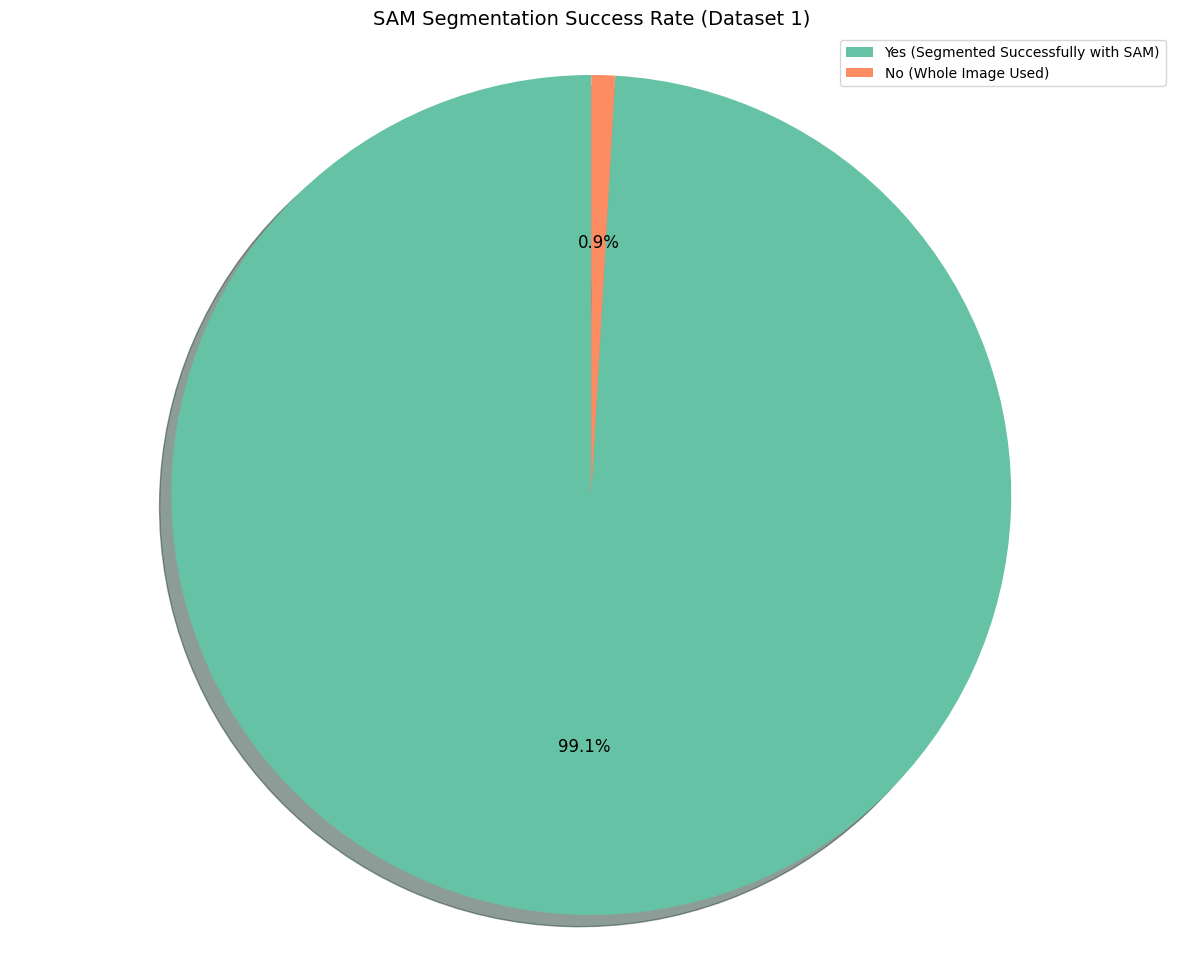

Dataset 1 (SAM) Successful Segmentations (Yes): 1304
Dataset 1 (SAM) Failed Segmentations (No): 12
Evaluation Results (YOLO):
eBay: Accuracy=0.2310, Precision=0.3725, Recall=0.2310, F1=0.1994
Vinted: Accuracy=0.1816, Precision=0.3651, Recall=0.1816, F1=0.1436


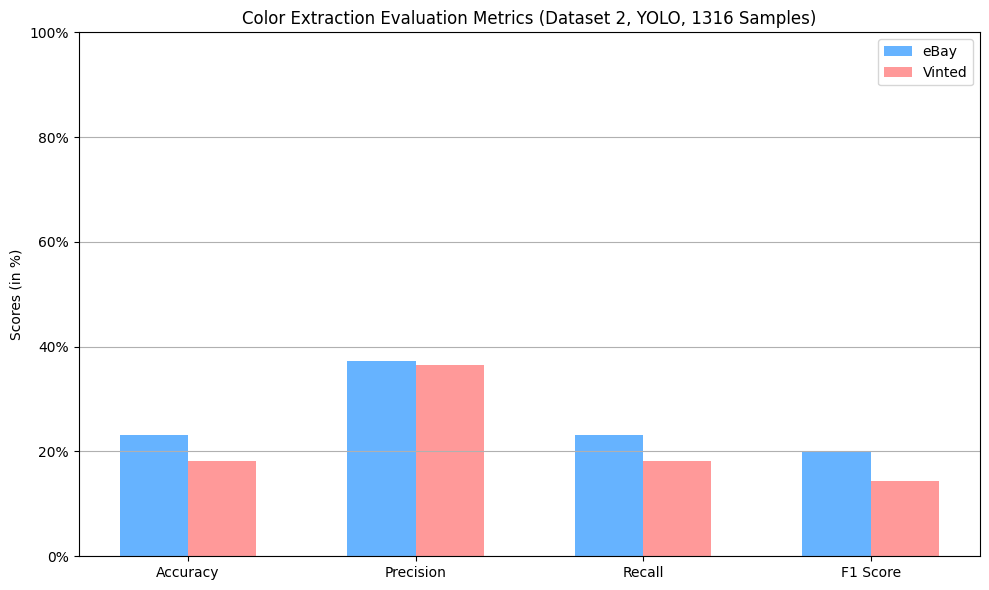

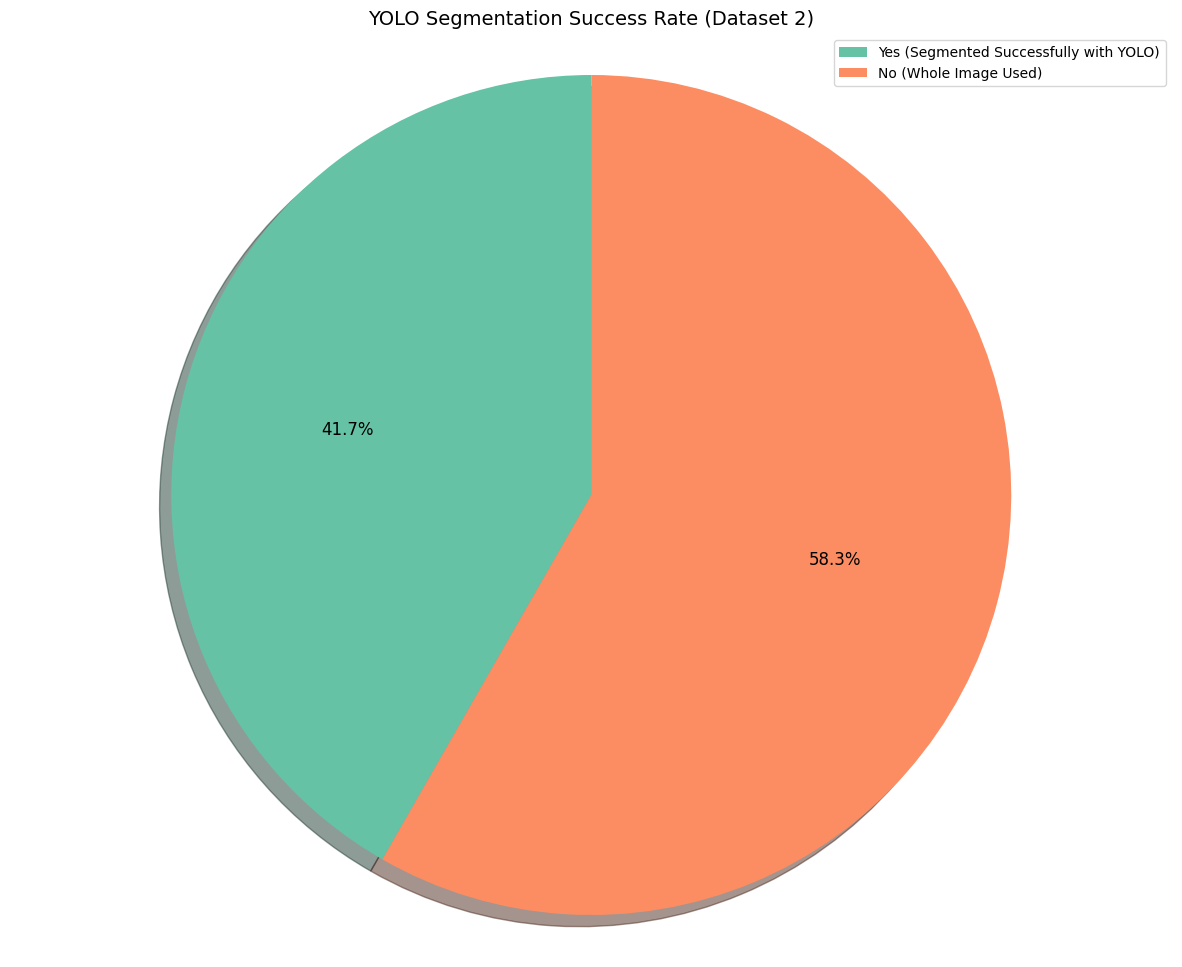

Dataset 2 (YOLO) Successful Segmentations (Yes): 549
Dataset 2 (YOLO) Failed Segmentations (No): 767
Evaluation Results (SAM):
eBay: Accuracy=0.2036, Precision=0.4169, Recall=0.2036, F1=0.2374
Vinted: Accuracy=0.1261, Precision=0.2674, Recall=0.1261, F1=0.1541


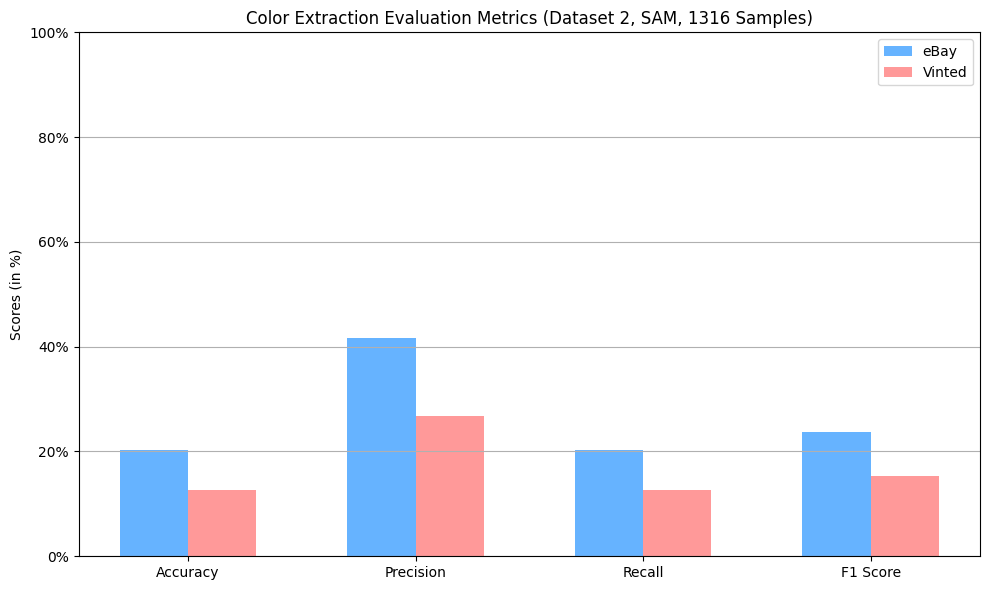

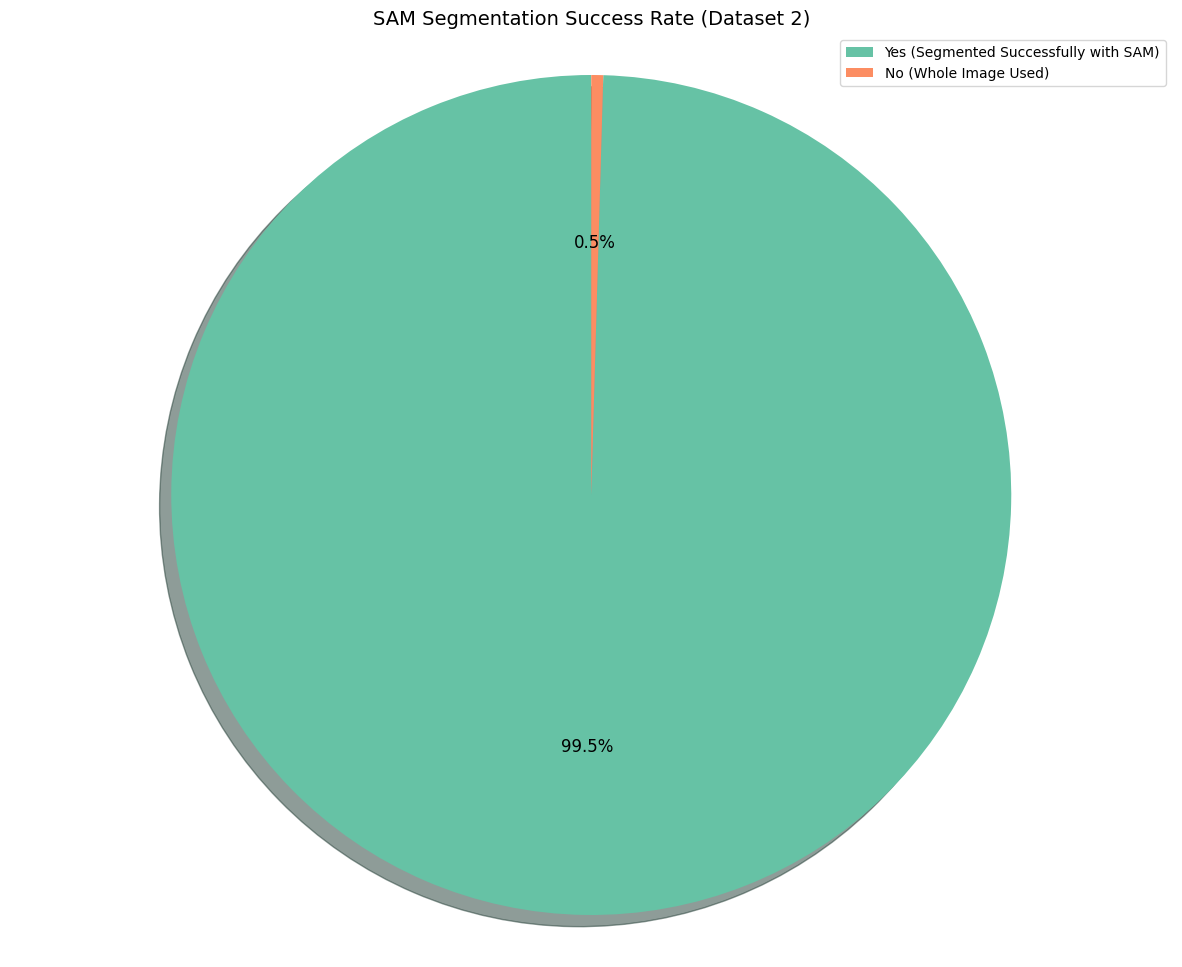

Dataset 2 (SAM) Successful Segmentations (Yes): 1310
Dataset 2 (SAM) Failed Segmentations (No): 6
Evaluation Results (YOLO):
eBay: Accuracy=0.2360, Precision=0.3508, Recall=0.2360, F1=0.2274
Vinted: Accuracy=0.1700, Precision=0.3190, Recall=0.1700, F1=0.1682


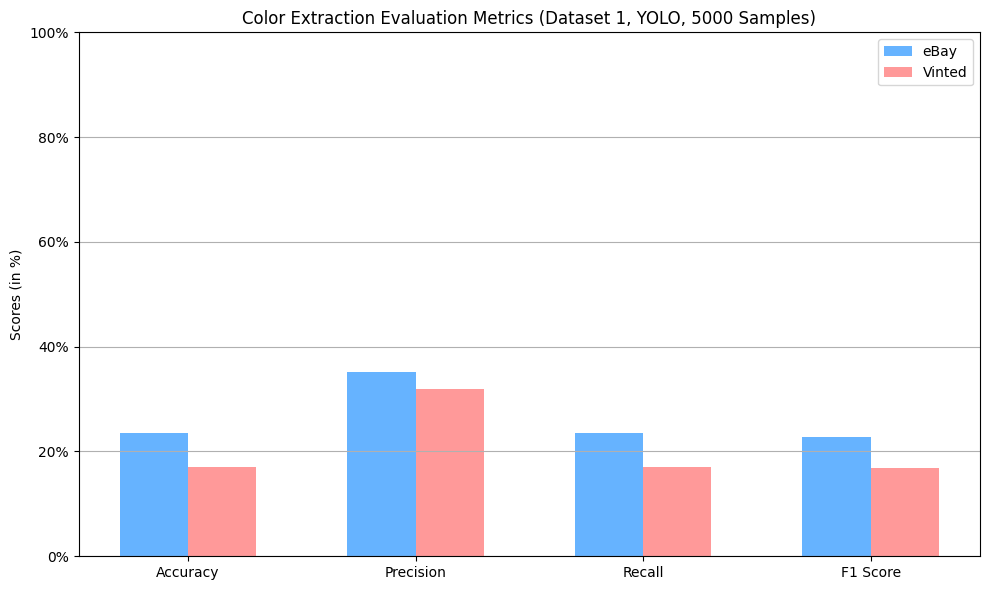

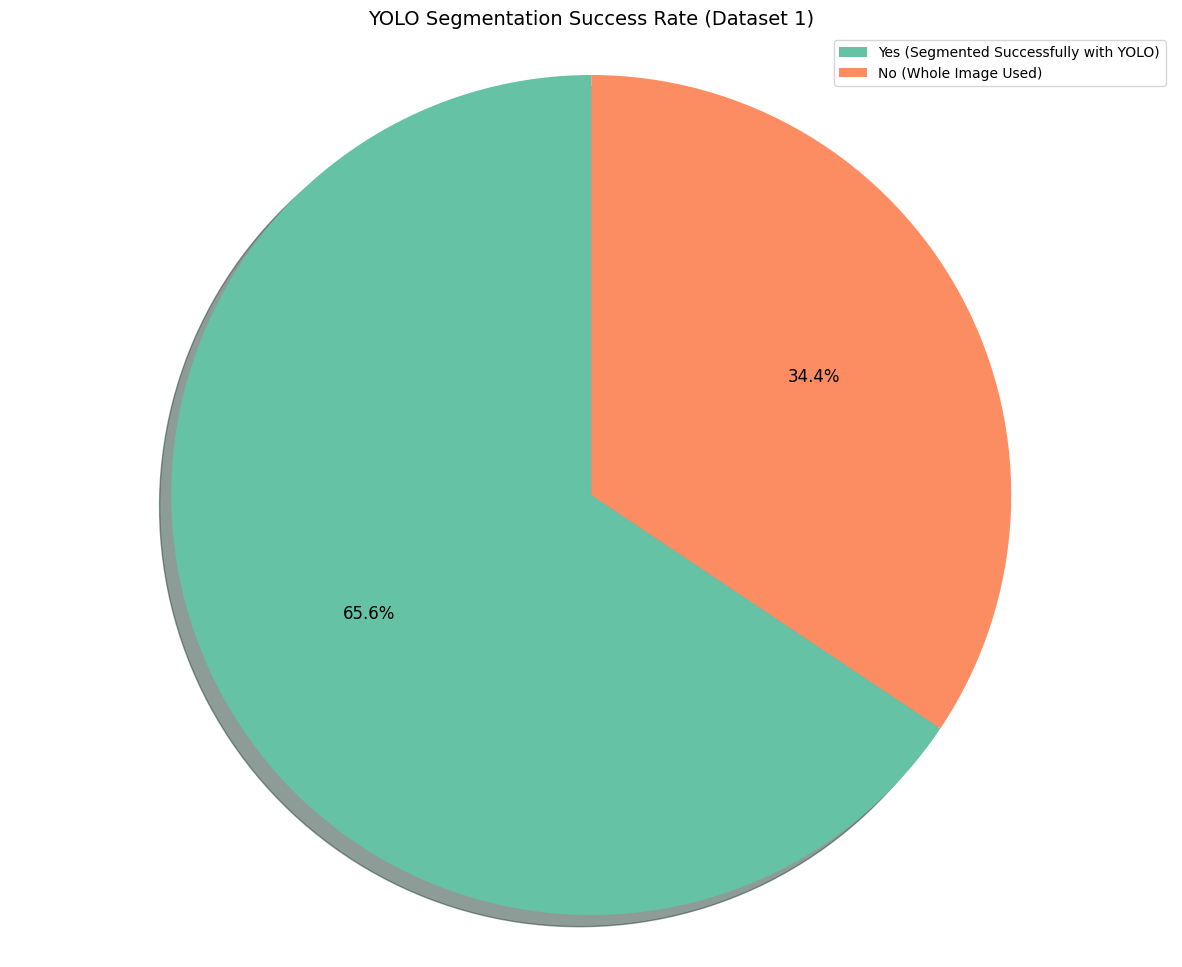

Dataset 1 (YOLO) Successful Segmentations (Yes): 3281
Dataset 1 (YOLO) Failed Segmentations (No): 1719


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base

Evaluation Results (SAM):
eBay: Accuracy=0.2750, Precision=0.3611, Recall=0.2750, F1=0.2738
Vinted: Accuracy=0.1918, Precision=0.3284, Recall=0.1918, F1=0.2042


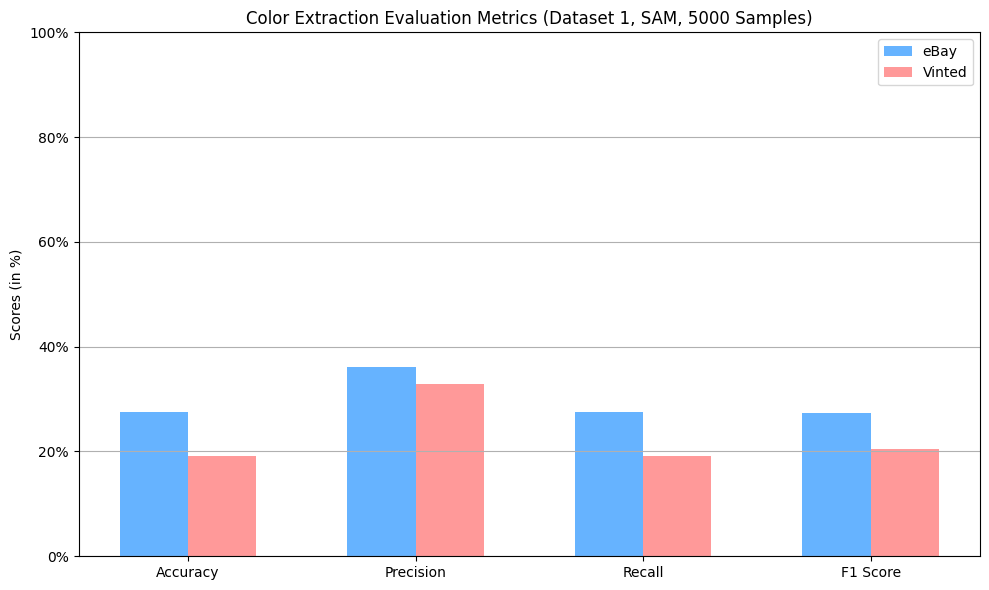

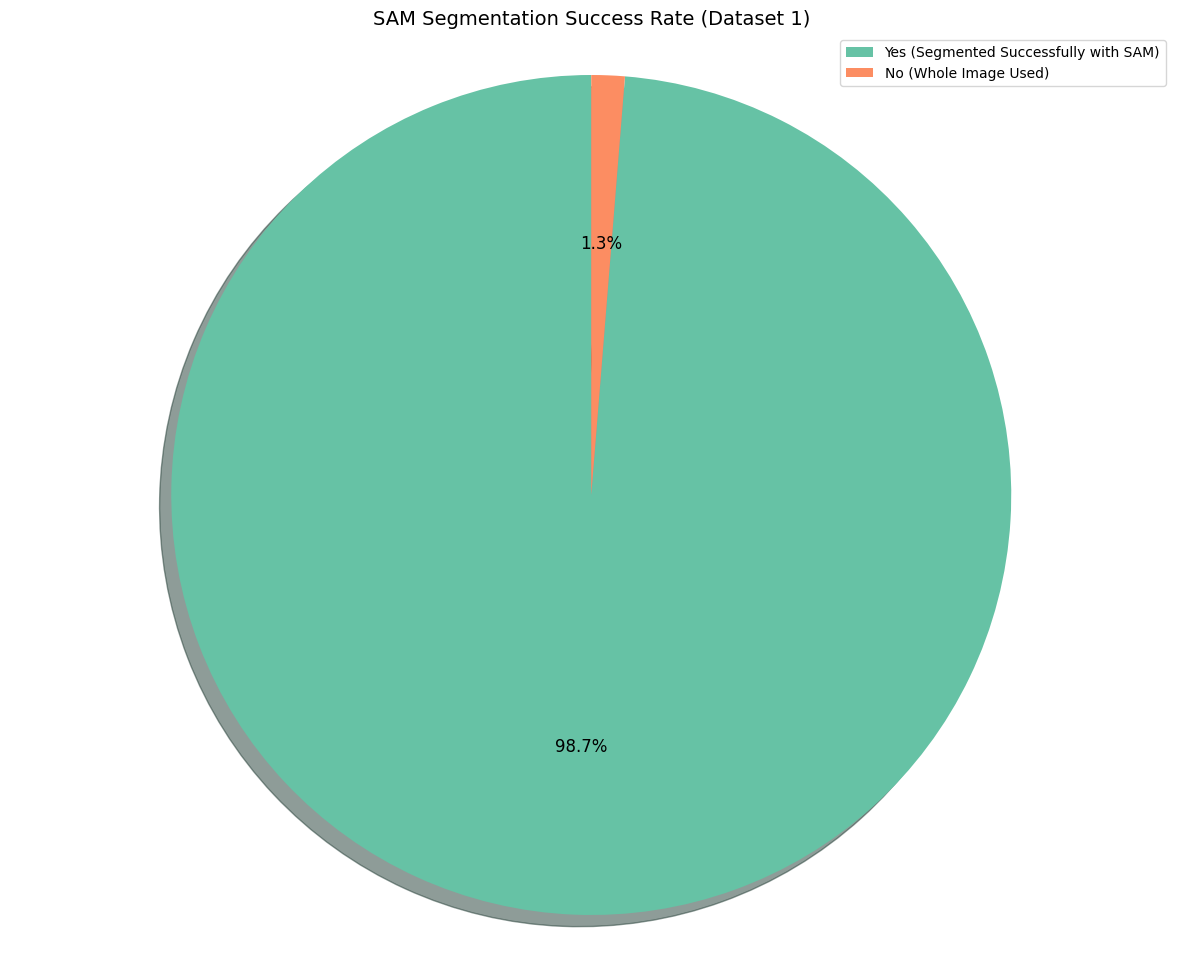

Dataset 1 (SAM) Successful Segmentations (Yes): 4936
Dataset 1 (SAM) Failed Segmentations (No): 64


In [18]:
# Evaluation with best found hyperparameters
num_samples = len(color_data2)

# Evaluate Dataset 1, YOLO
eval_results1_yolo = evaluate_model(
    color_data1, color_map_dataset1, 'baseColour', num_samples, yolo_model,
    best_params_d1_yolo['n_clusters'], best_params_d1_yolo['max_iter'], 'yolo', verbose=True
)
visualize_evaluation(eval_results1_yolo, 'Dataset 1', num_samples, 'yolo', verbose=True)

# Evaluate Dataset 1, SAM
eval_results1_sam = evaluate_model(
    color_data1, color_map_dataset1, 'baseColour', num_samples, sam_model,
    best_params_d1_sam['n_clusters'], best_params_d1_sam['max_iter'], 'sam', verbose=True
)
visualize_evaluation(eval_results1_sam, 'Dataset 1', num_samples, 'sam', verbose=True)

# Evaluate Dataset 2, YOLO
eval_results2_yolo = evaluate_model(
    color_data2, color_map_dataset2, 'Colour', num_samples, yolo_model,
    best_params_d2_yolo['n_clusters'], best_params_d2_yolo['max_iter'], 'yolo', verbose=True
)
visualize_evaluation(eval_results2_yolo, 'Dataset 2', num_samples, 'yolo', verbose=True)

# Evaluate Dataset 2, SAM
eval_results2_sam = evaluate_model(
    color_data2, color_map_dataset2, 'Colour', num_samples, sam_model,
    best_params_d2_sam['n_clusters'], best_params_d2_sam['max_iter'], 'sam', verbose=True
)
visualize_evaluation(eval_results2_sam, 'Dataset 2', num_samples, 'sam', verbose=True)

num_samples = 5000

# Evaluate Dataset 1, YOLO (5000 Samples)
eval_results1_yolo = evaluate_model(
    color_data1, color_map_dataset1, 'baseColour', num_samples, yolo_model,
    best_params_d1_yolo['n_clusters'], best_params_d1_yolo['max_iter'], 'yolo', verbose=True
)
visualize_evaluation(eval_results1_yolo, 'Dataset 1', num_samples, 'yolo', verbose=True)

# Evaluate Dataset 1, SAM (5000 Samples)
eval_results1_sam = evaluate_model(
    color_data1, color_map_dataset1, 'baseColour', num_samples, sam_model,
    best_params_d1_sam['n_clusters'], best_params_d1_sam['max_iter'],  'sam', verbose=True
)
visualize_evaluation(eval_results1_sam, 'Dataset 1', num_samples, 'sam', verbose=True)